In [13]:
# Install yfinance if not already installed
import yfinance as yf
import pandas as pd     
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# packages for MLR
from sklearn import linear_model

# packages we need for the Neural Net
from keras.models import Sequential
from keras.layers import Dense


In [14]:
data = yf.download("AAPL", start="2014-01-01", end="2024-01-01", auto_adjust=False)
data.to_csv("AAPL.csv")

[*********************100%***********************]  1 of 1 completed


In [15]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2014-01-02,17.156704,19.754642,19.893929,19.715000,19.845715,234684800
2014-01-03,16.779844,19.320715,19.775000,19.301071,19.745001,392467600
2014-01-06,16.871342,19.426071,19.528570,19.057142,19.194643,412610800
2014-01-07,16.750681,19.287144,19.498571,19.211430,19.440001,317209200
2014-01-08,16.856764,19.409286,19.484285,19.238930,19.243214,258529600


In [16]:
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [17]:
data_adj = data[['Adj Close']].copy()
data_adj.columns = ['price']

In [18]:
data_adj

,price
Date,
2014-01-02,17.156704
2014-01-03,16.779844
2014-01-06,16.871342
2014-01-07,16.750681
2014-01-08,16.856764
...,...
2023-12-22,191.788773
2023-12-26,191.243881
2023-12-27,191.342972


In [19]:
# Create 1-day lag
data_adj['lag_1'] = data_adj['price'].shift(1)
data_adj.dropna(inplace=True)
data_adj.head()

,price,lag_1
Date,,
2014-01-03,16.779844,17.156704
2014-01-06,16.871342,16.779844
2014-01-07,16.750681,16.871342
2014-01-08,16.856764,16.750681
2014-01-09,16.641506,16.856764


In [20]:
# Create a complete business day index range
all_business_days = pd.date_range(start=data_adj.index.min(), end=data_adj.index.max(), freq='B')

# Reindex data_adj to this range to include holidays as NaNs
data_filled = data_adj.reindex(all_business_days)

# Estimate values for holidays using interpolation
data_filled['price'] = data_filled['price'].interpolate(method='time')

# Shift by 5 to get the 1-week lag (same day previous week)
data_filled['lag_5_week'] = data_filled['price'].shift(5)

# Merge the new lag feature back to the original data_adj
# We use join to map back to the trading days only
data_adj = data_adj.join(data_filled[['lag_5_week']], how='left')

# Drop rows with NaN (created by shifting)
data_adj.dropna(inplace=True)

print("Added lag_5_week feature with holiday estimation.")
data_adj.head()

Added lag_5_week feature with holiday estimation.


,price,lag_1,lag_5_week
Date,,,
2014-01-10,16.530458,16.641506,16.779844
2014-01-13,16.616999,16.530458,16.871342
2014-01-14,16.947641,16.616999,16.750681
2014-01-15,17.287901,16.947641,16.856764
2014-01-16,17.191437,17.287901,16.641506


In [21]:
data_adj['day_of_the_week'] = data_adj.index.dayofweek

In [22]:
data_adj[0:15]

,price,lag_1,lag_5_week,day_of_the_week
Date,,,,
2014-01-10,16.530458,16.641506,16.779844,4
2014-01-13,16.616999,16.530458,16.871342,0
2014-01-14,16.947641,16.616999,16.750681,1
2014-01-15,17.287901,16.947641,16.856764,2
2014-01-16,17.191437,17.287901,16.641506,3
2014-01-17,16.770229,17.191437,16.530458,4
2014-01-21,17.030775,16.770229,16.947641,1
2014-01-22,17.106451,17.030775,17.287901,2
2014-01-23,17.251303,17.106451,17.191437,3


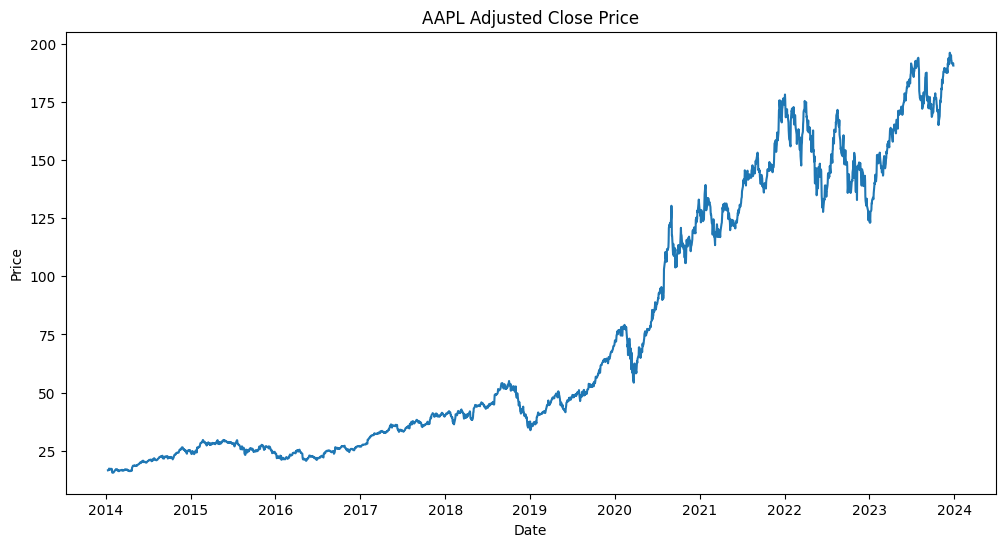

In [23]:
# Plot the current data
plt.figure(figsize=(12, 6))
plt.plot(data_adj.index, data_adj['price'])
plt.title('AAPL Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [24]:
# Split the data into training and testing data (75:25)
split_index = int(len(data_adj) * 0.75)
train_data = data_adj.iloc[:split_index]
test_data = data_adj.iloc[split_index:]

print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

Training samples: 1882
Testing samples: 628


In [25]:
# Create a separate matrix called features that holds zeros
features = np.zeros((len(data_adj), 3))
# Add the lagged features
# column 0 is the constant (beta_0)
# column 1 is the lagged price (beta_1 * l_{t-1})
for i in range(len(data_adj)):
    features[i, 0] = 1
    features[i, 1] = data_adj['lag_1'].iloc[i]
    features[i, 2] = data_adj['lag_5_week'].iloc[i]
# Create testing features and training features
X_train = features[:split_index]
y_train = data_adj['price'].iloc[:split_index].values
X_test = features[split_index:]
y_test = data_adj['price'].iloc[split_index:].values


In [26]:
# Use NN (Neural Network) for predicting the data
# Model: y_hat = beta_0 + beta_1 * l_{t-1}

model_nn = Sequential()
model_nn.add(Dense(8, input_dim=3, activation='relu')) # Hidden layer
model_nn.add(Dense(8, activation='relu')) # Hidden layer
model_nn.add(Dense(1)) # Output layer
model_nn.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_nn.fit(X_train, y_train, epochs=20, batch_size=5, verbose=1)


/home/jarvis/Main/Projects/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1764023032.137350   18768 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1764023032.163275   18768 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3236.4104
Epoch 2/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 992.6346 
Epoch 3/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5120
Epoch 4/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1943
Epoch 5/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8795
Epoch 6/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6456
Epoch 7/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.3878
Epoch 8/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2324
Epoch 9/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0774
Epoch 10/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9117
Epoch 11/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8777
Epoch 12/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8585
Epoch 13/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8812
Epoch 14/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8417
Epoch 15/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

In [27]:
# Use Multiple Linear Regression (MLR) for predicting the data
MLR1 = linear_model.LinearRegression(fit_intercept=False)
MLR1.fit(X_train, y_train)

,fit_intercept,False
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [28]:
# Predictions
y_pred_nn = model_nn.predict(X_test)
y_pred_mlr = MLR1.predict(X_test)
y_train_pred_nn = model_nn.predict(X_train)
y_train_pred_mlr = MLR1.predict(X_train)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [29]:
# Calculate MAPE
def calculate_mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_pred.flatten() - y_true.flatten()) / y_true.flatten()))

nn_train_mape = calculate_mape(y_train, y_train_pred_nn)
nn_test_mape = calculate_mape(y_test, y_pred_nn)
mlr_train_mape = calculate_mape(y_train, y_train_pred_mlr)
mlr_test_mape = calculate_mape(y_test, y_pred_mlr)

print(f'NN Training MAPE: {nn_train_mape:.2f}%')
print(f'NN Testing MAPE: {nn_test_mape:.2f}%')
print(f'MLR Training MAPE: {mlr_train_mape:.2f}%')
print(f'MLR Testing MAPE: {mlr_test_mape:.2f}%')

NN Training MAPE: 1.32%
NN Testing MAPE: 1.43%
MLR Training MAPE: 1.23%
MLR Testing MAPE: 1.30%


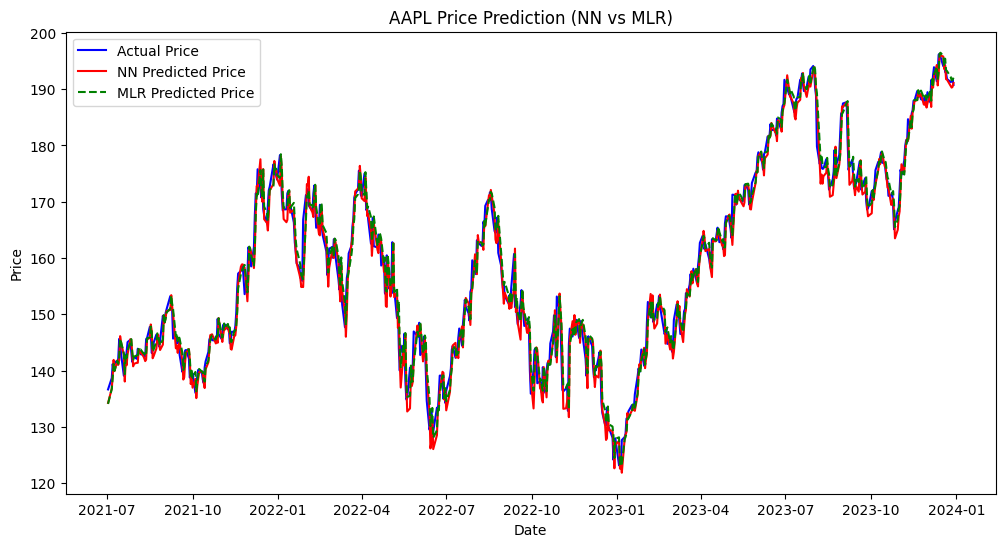

In [38]:
# Predict and plot the prediction in a graph
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual Price', color='blue')
plt.plot(test_data.index, y_pred_nn, label='NN Predicted Price', color='red')
plt.plot(test_data.index, y_pred_mlr, label='MLR Predicted Price', color='green', linestyle='--')
plt.title('AAPL Price Prediction (NN vs MLR)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [31]:
data_adj.head()

,price,lag_1,lag_5_week,day_of_the_week
Date,,,,
2014-01-10,16.530458,16.641506,16.779844,4
2014-01-13,16.616999,16.530458,16.871342,0
2014-01-14,16.947641,16.616999,16.750681,1
2014-01-15,17.287901,16.947641,16.856764,2
2014-01-16,17.191437,17.287901,16.641506,3


In [32]:
data_adj['day_of_the_week'] = data_adj.index.dayofweek

In [33]:
data_adj.head()

,price,lag_1,lag_5_week,day_of_the_week
Date,,,,
2014-01-10,16.530458,16.641506,16.779844,4
2014-01-13,16.616999,16.530458,16.871342,0
2014-01-14,16.947641,16.616999,16.750681,1
2014-01-15,17.287901,16.947641,16.856764,2
2014-01-16,17.191437,17.287901,16.641506,3
